In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [186]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
import itertools

In [3]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [124]:
# datasets
sales_train = pd.read_csv('demand_forecasting_train_1_month.csv')
sales_test = pd.read_csv('demand_forecasting_test.csv')
house_train = pd.read_csv('house_prices_train.csv')
house_test = pd.read_csv('house_prices_test.csv')
taxi_train = pd.read_csv('taxi_train_chapter_4.csv')
taxi_test = pd.read_csv('taxi_test_chapter_4.csv')

kobe_cols = ['shot_id', 'game_id', 'lat', 'lon', 'minutes_remaining', 'playoffs', 'season', 'shot_distance', 'shot_type', 'shot_made_flag']
kobe = pd.read_csv('kobe.csv', usecols=kobe_cols).dropna()
kobe = kobe[kobe_cols]

# Prepare your first submission

## Train a simple model: demand forecasting

In [5]:
sales_train.head()

,id,date,store,item,sales
0,100000,2017-12-01,1,1,19
1,100001,2017-12-02,1,1,16
2,100002,2017-12-03,1,1,31
3,100003,2017-12-04,1,1,7
4,100004,2017-12-05,1,1,20


In [6]:
# instantiate a random forest regressor and fit
rf = RandomForestRegressor()

rf.fit(X=sales_train[['store', 'item']],
       y=sales_train['sales'])

RandomForestRegressor()

## Prepare a submission

In [7]:
sales_test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [8]:
# get preds for test set
sales_test['sales'] = rf.predict(sales_test[['store', 'item']])

# write test preds using the submission format
sales_test[['id', 'sales']].to_csv('kaggle_submission.csv', index=False)

# Public vs. Private leaderboard

## Train XGBoost models

In [9]:
# create DMatrix on train data
dtrain = xgb.DMatrix(data=sales_train[['store', 'item']],
                     label=sales_train['sales'])

# define xgboost params
params = {'objective': 'reg:linear',
          'max_depth': 2,
          'silent': 1}

# train xgboost model
xg_depth_2 = xgb.train(params=params,
                       dtrain=dtrain)

In [10]:
# create DMatrix on train data
dtrain = xgb.DMatrix(data=sales_train[['store', 'item']],
                     label=sales_train['sales'])

# define xgboost params
params = {'objective': 'reg:linear',
          'max_depth': 8,
          'silent': 1}

# train xgboost model
xg_depth_8 = xgb.train(params=params,
                       dtrain=dtrain)

In [11]:
# create DMatrix on train data
dtrain = xgb.DMatrix(data=sales_train[['store', 'item']],
                     label=sales_train['sales'])

# define xgboost params
params = {'objective': 'reg:linear',
          'max_depth': 100,
          'silent': 1}

# train xgboost model
xg_depth_100 = xgb.train(params=params,
                       dtrain=dtrain)

## Explore overfitting XGBoost

In [12]:
dtrain = xgb.DMatrix(data=sales_train[['store', 'item']])
dtest = xgb.DMatrix(data=sales_test[['store', 'item']])

# for each of 3 models, get MSE for train and test
for model in [xg_depth_2, xg_depth_8, xg_depth_100]:
    
    train_pred = model.predict(dtrain)
    test_pred = model.predict(dtest)
    
    mse_train = mean_squared_error(sales_train['sales'], train_pred)
    mse_test = mean_squared_error(sales_test['sales'], test_pred)
    
    print(f'Train MSE: {mse_train: .2f}, Test MSE: {mse_test: .2f}')

Train MSE:  331.06, Test MSE:  249.16
Train MSE:  112.06, Test MSE:  30.42
Train MSE:  83.84, Test MSE:  2.36


This isn't accurate, no ground truth for test (the one used here was from the `rf` preds). But typically, as you increase `max_depth`, you are more prone to overfit. That's what we'd expect to see.

# Understand the problem

## Define a competition metric

In [14]:
# define own MSE fxn
def own_mse(y_true, y_pred):
    squares = np.power(y_true - y_pred, 2)
    err = np.mean(squares)
    
    return err

# define own LogLoss fxn
def own_logloss(y_true, prob_pred):
    terms = y_true * np.log(prob_pred) + (1 - y_true) * np.log(1 - prob_pred)
    err = np.mean(terms)
    
    return -err

## Initial EDA - Taxi Fare Prediction

In [18]:
print(f'Train shape: {taxi_train.shape}')
print(f'Test shape: {taxi_test.shape}')

Train shape: (20000, 8)
Test shape: (9914, 7)


In [19]:
taxi_train.head()

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [20]:
taxi_train.describe()

,id,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,9999.500000,11.303321,-72.478584,39.921043,-72.497221,39.913606,1.658000
std,5773.647028,9.541637,10.525376,6.678592,10.460530,6.139231,1.283674
min,0.000000,-3.000000,-74.438233,-74.006893,-84.654241,-74.006377,0.000000
25%,4999.750000,6.000000,-73.992150,40.734706,-73.991224,40.734537,1.000000
50%,9999.500000,8.500000,-73.981711,40.752680,-73.980217,40.753583,1.000000
75%,14999.250000,12.500000,-73.966802,40.767443,-73.963729,40.768135,2.000000
max,19999.000000,180.000000,40.766125,401.083332,40.802437,41.366138,6.000000


In [26]:
taxi_train['passenger_count'].value_counts()

1    13999
2     2912
5     1327
3      860
4      420
6      407
0       75
Name: passenger_count, dtype: int64

## EDA plots I

In [28]:
def haversine_distance(train):
    
    data = [train]
    lat1, long1, lat2, long2 = 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'
    
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        
    return d

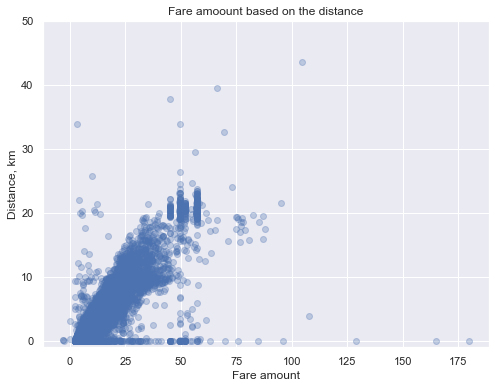

In [48]:
taxi_train_ = taxi_train.copy()

# calculate the ride distance
taxi_train_['distance_km'] = haversine_distance(taxi_train_)

# plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x=taxi_train_['fare_amount'],
           y=taxi_train_['distance_km'],
           alpha=0.3)
ax.set(xlabel='Fare amount',
       ylabel='Distance, km',
       title='Fare amoount based on the distance',
       ylim=[-1, 50])

plt.show()

There is a clear dependency between `distance_km` and `fare_amount`. So, `distance_km` is probably a good feature.

## EDA plots II

In [50]:
taxi_train_['pickup_datetime'] = pd.to_datetime(taxi_train_['pickup_datetime'])
taxi_train_['hour'] = taxi_train_['pickup_datetime'].dt.hour

In [51]:
# find median fare_ammount for each hour
hour_price = taxi_train_.groupby('hour', as_index=False)['fare_amount'].median()

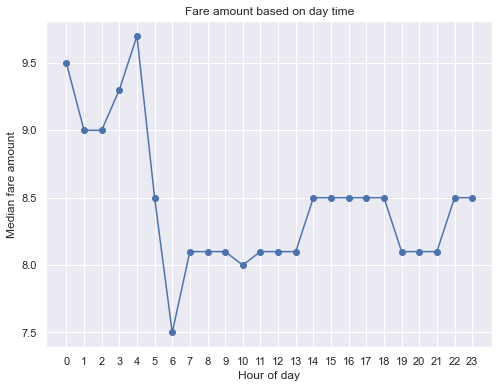

In [53]:
# plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(hour_price['hour'],
        hour_price['fare_amount'],
        marker='o')
ax.set(xlabel='Hour of day',
       ylabel='Median fare amount',
       title='Fare amount based on day time',
       xticks=range(24))

plt.show()

We see that prices are a bit higher during the night. It is a good indicator that we should include the `hour` feature in the final model, or at least add a binary feature `is_night`.

# Local validation

## K-Fold cross-validation

## Stratified K-Fold

~~Class imbalance -> Stratified K-Fold~~
For any classification problem, stratified > usual K-Fold for size and target distributions are the same.

# Validation usage

## Time K-Fold

In [62]:
sales_train_ = sales_train.copy()

In [67]:
# create TimeSeriesSplit obj
time_kf = TimeSeriesSplit(n_splits=3)

# sort train data by date
sales_train_ = sales_train_.sort_values('date')

# iterate through each split
fold = 0
for tr, tt in time_kf.split(sales_train_):
    cv_train, cv_test = sales_train_.iloc[tr], sales_train_.iloc[tt]
    
    print(f'Fold: {fold}')
    print(f'Train date range from {cv_train["date"].min()} to {cv_train["date"].max()}')
    print(f'Test date range from {cv_test["date"].min()} to {cv_test["date"].max()}')
    
    fold += 1

Fold: 0
Train date range from 2017-12-01 to 2017-12-08
Test date range from 2017-12-08 to 2017-12-16
Fold: 1
Train date range from 2017-12-01 to 2017-12-16
Test date range from 2017-12-16 to 2017-12-24
Fold: 2
Train date range from 2017-12-01 to 2017-12-24
Test date range from 2017-12-24 to 2017-12-31


## Overall validation score

In [68]:
def get_fold_mse(train, kf):
    mse_scores = []
    
    for train_index, test_index in kf.split(train):
        fold_train, fold_test = train.loc[train_index], train.loc[test_index]

        # Fit the data and make predictions
        # Create a Random Forest object
        rf = RandomForestRegressor(n_estimators=10, random_state=123)

        # Train a model
        rf.fit(X=fold_train[['store', 'item']], y=fold_train['sales'])

        # Get predictions for the test set
        pred = rf.predict(fold_test[['store', 'item']])
    
        fold_score = round(mean_squared_error(fold_test['sales'], pred), 5)
        mse_scores.append(fold_score)
        
    return mse_scores

In [73]:
# initialize 3-fold time cv
kf = TimeSeriesSplit(n_splits=3)

# get MSE scores for each split
mse_scores = get_fold_mse(sales_train_, kf)

print(f'Mean Val MSE: {np.mean(mse_scores): .2f}')
print(f'MSE by fold:\n{mse_scores}')
print(f'Overall Val MSE: {np.mean(mse_scores) + np.std(mse_scores): .2f}')

Mean Val MSE:  955.49
MSE by fold:
[890.30336, 961.65797, 1014.51424]
Overall Val MSE:  1006.39


# Feature engineering

## Arithmetical features

In [77]:
def get_kfold_rmse(train):
    mse_scores = []

    for train_index, test_index in kf.split(train):
        train = train.fillna(0)
        feats = [x for x in train.columns if x not in ['Id', 'SalePrice', 'RoofStyle', 'CentralAir']]
        
        fold_train, fold_test = train.loc[train_index], train.loc[test_index]

        # Fit the data and make predictions
        # Create a Random Forest object
        rf = RandomForestRegressor(n_estimators=10, min_samples_split=10, random_state=123)

        # Train a model
        rf.fit(X=fold_train[feats], y=fold_train['SalePrice'])

        # Get predictions for the test set
        pred = rf.predict(fold_test[feats])
    
        fold_score = mean_squared_error(fold_test['SalePrice'], pred)
        mse_scores.append(np.sqrt(fold_score))
        
    return round(np.mean(mse_scores) + np.std(mse_scores), 2)

In [78]:
house_train.head()

,Id,LotArea,OverallQual,YearBuilt,RoofStyle,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
0,1,8450,7,2003,Gable,856,Y,856,854,2,1,3,1,8,2,548,208500
1,2,9600,6,1976,Gable,1262,Y,1262,0,2,0,3,1,6,2,460,181500
2,3,11250,7,2001,Gable,920,Y,920,866,2,1,3,1,6,2,608,223500
3,4,9550,7,1915,Gable,756,Y,961,756,1,0,3,1,7,3,642,140000
4,5,14260,8,2000,Gable,1145,Y,1145,1053,2,1,4,1,9,3,836,250000


In [89]:
house_train_ = house_train.copy()

In [90]:
# look at initial RMSE
print(f'RMSE before feature engineering: {get_kfold_rmse(house_train_)}')

# find the total area of the house
house_train_['TotalArea'] = house_train_['TotalBsmtSF'] + house_train_['1stFlrSF'] + house_train_['2ndFlrSF']

# look at updated RMSE
print(f'RMSE with TotalArea: {get_kfold_rmse(house_train_)}')

# find area of garden
house_train_['GardenArea'] = house_train_['LotArea'] - house_train_['1stFlrSF']
print(f'RMSE with GardenArea {get_kfold_rmse(house_train_)}')

# find total no. of bathrooms
house_train_['TotalBath'] = house_train_['FullBath'] + house_train_['HalfBath']
print(f'RMSE with TotalBath: {get_kfold_rmse(house_train_)}')

RMSE before feature engineering: 39774.72
RMSE with TotalArea: 36823.99
RMSE with GardenArea 36736.5
RMSE with TotalBath: 36624.96


## Date features

In [102]:
# concatenate train and test
taxi = pd.concat([taxi_train, taxi_test])

# convert to datetime
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])

# extract date features
taxi['dayofweek'] = taxi['pickup_datetime'].dt.dayofweek
taxi['hour'] = taxi['pickup_datetime'].dt.hour

# split back
taxi_train_new = taxi.iloc[:20000]
taxi_test_new = taxi.iloc[20000:]

# Categorical features

## Label encoding

In [109]:
# concatenate train and test together
houses = pd.concat([house_train, house_test])

# label encoder
le = LabelEncoder()

# create new features
houses['RoofStyle_enc'] = le.fit_transform(houses['RoofStyle'])
houses['CentralAir_enc'] = le.fit_transform(houses['CentralAir'])

# look at new features
houses[['RoofStyle', 'RoofStyle_enc', 'CentralAir', 'CentralAir_enc']].head()

,RoofStyle,RoofStyle_enc,CentralAir,CentralAir_enc
0,Gable,1,Y,1
1,Gable,1,Y,1
2,Gable,1,Y,1
3,Gable,1,Y,1
4,Gable,1,Y,1


## One-Hot encoding

In [111]:
# concatenate train and test together
houses = pd.concat([house_train, house_test])

# look at feature distributions
print(houses['RoofStyle'].value_counts(), '\n')
print(houses['CentralAir'].value_counts())

Gable      2310
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64 

Y    2723
N     196
Name: CentralAir, dtype: int64


In [112]:
# label encode binary 'CentralAir' feature
le = LabelEncoder()
houses['CentralAir_enc'] = le.fit_transform(houses['CentralAir'])

In [113]:
# create one-hot encoded features
ohe = pd.get_dummies(houses['RoofStyle'], prefix='RoofStyle')

# concat OEHE features to houses
houses = pd.concat([houses, ohe], axis=1)

houses[[col for col in houses.columns if 'RoofStyle' in col]].head()

,RoofStyle,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
0,Gable,0,1,0,0,0,0
1,Gable,0,1,0,0,0,0
2,Gable,0,1,0,0,0,0
3,Gable,0,1,0,0,0,0
4,Gable,0,1,0,0,0,0


# Target encoding

## Mean target encoding

In [131]:
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # calculate global mean on train data
    global_mean = train[target].mean()
    
    # group by categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # calculate smoothed mean target statistics
    train_stats = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # apply stats to test data and fill new categories
    test_feature = test[categorical].map(train_stats).fillna(global_mean)
    
    return test_feature.values

def train_mean_target_encoding(train, target, categorical, alpha=5):
    # create 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=123, shuffle=True)
    train_feature = pd.Series(index=train.index, dtype='float')
    
    # for each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    
    return train_feature.values

def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
  
    # get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # return new features to add to the model
    return train_feature, test_feature

## K-Fold cross-validation

In [132]:
# create 5-fold cv
kf = KFold(n_splits=5,
           random_state=123,
           shuffle=True)

# for each split, do mean target encoding
for tr, tt, in kf.split(kobe):
    cv_train, cv_test = kobe.iloc[tr], kobe.iloc[tt]
    
    cv_train['game_id_enc'], cv_test['game_id_enc'] = mean_target_encoding(train=cv_train,
                                                                           test=cv_test,
                                                                           target='shot_made_flag',
                                                                           categorical='game_id',
                                                                           alpha=5)
    
    # look at encoding
    print(cv_train[['game_id', 'shot_made_flag', 'game_id_enc']].sample(n=1))

C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

        game_id  shot_made_flag  game_id_enc
10428  20600580             0.0     0.517864
       game_id  shot_made_flag  game_id_enc
3775  20200404             1.0        0.222
        game_id  shot_made_flag  game_id_enc
15728  20900543             1.0     0.234917
        game_id  shot_made_flag  game_id_enc
18661  21100357             0.0     0.415427
        game_id  shot_made_flag  game_id_enc
27954  40600152             0.0     0.436722


C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Beyond binary classification

In [133]:
house_train_, house_test_ = house_train.copy(), house_test.copy()

# Create mean target encoded feature
house_train_['RoofStyle_enc'], house_test_['RoofStyle_enc'] = mean_target_encoding(train=house_train_,
                                                                                   test=house_test_,
                                                                                   target='SalePrice',
                                                                                   categorical='RoofStyle',
                                                                                   alpha=10)

# Look at the encoding
print(house_test_[['RoofStyle', 'RoofStyle_enc']].drop_duplicates())

     RoofStyle  RoofStyle_enc
0        Gable  171565.947836
1          Hip  217594.645131
98     Gambrel  164152.950424
133       Flat  188703.563431
362    Mansard  180775.938759
1053      Shed  188267.663242


# Missing data

## Find missing data

## Impute missing data

# Baseline model

In [155]:
taxi_train.head()

,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## Replicate validation score

In [148]:
train, val = train_test_split(taxi_train,
                              test_size=0.3,
                              random_state=42)

In [149]:
# calculate the mean fare_amount on the train data
naive_pred = np.mean(train['fare_amount'])

# assign the naive prediction to all validation set
val['pred'] = naive_pred

# measure RMSE
rmse = np.sqrt(mean_squared_error(val['fare_amount'], val['pred']))
print(f'Validation RMSE for Baseline I: {rmse: .2f}')

Validation RMSE for Baseline I:  9.51


C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Baseline based on the date

In [154]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
val['pickup_datetime'] = pd.to_datetime(val['pickup_datetime'])

# get pickup hour
train['hour'] = train['pickup_datetime'].dt.hour
val['hour'] = val['pickup_datetime'].dt.hour

# calc avg fare_amount grouped by pickup hour
hour_groups = train.groupby('hour')['fare_amount'].mean()

val['pred'] = val['hour'].map(hour_groups)

# measure RMSE
rmse = np.sqrt(mean_squared_error(val['fare_amount'], val['pred']))
print(f'Validation RMSE for Baseline II: {rmse: .2f}')

Validation RMSE for Baseline II:  9.49


C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

## Baseline based on gradient boosting

In [157]:
# Select only numeric features
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
            'dropoff_latitude', 'passenger_count', 'hour']

# Train a Random Forest model
rf = RandomForestRegressor()
rf.fit(train[features], train['fare_amount'])

# Make predictions on the test data
val['pred'] = rf.predict(val[features])

# measure RMSE
rmse = np.sqrt(mean_squared_error(val['fare_amount'], val['pred']))
print(f'Validation RMSE for Baseline III: {rmse: .2f}')

Validation RMSE for Baseline III:  4.80


C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


# Hyperparameter tuning

In [165]:
train['distance_km'] = haversine_distance(train)
val['distance_km'] = haversine_distance(val)

features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
            'dropoff_latitude', 'passenger_count', 'distance_km', 'hour']

C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Grid Search

In [167]:
def get_cv_score(train, params):
    # Create KFold object
    kf = KFold(n_splits=3, shuffle=True, random_state=123)

    rmse_scores = []
    
    # Loop through each split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    
        # Train a Gradient Boosting model
        gb = GradientBoostingRegressor(random_state=123, **params).fit(cv_train[features], cv_train.fare_amount)
    
        # Make predictions on the test data
        pred = gb.predict(cv_test[features])
    
        fold_score = np.sqrt(mean_squared_error(cv_test['fare_amount'], pred))
        rmse_scores.append(fold_score)
    
    return np.round(np.mean(rmse_scores) + np.std(rmse_scores), 5)

In [168]:
# Possible max depth values
max_depth_grid = [3, 6, 9, 12, 15]
results = {}

# For each value in the grid
for max_depth_candidate in max_depth_grid:
    # Specify parameters for the model
    params = {'max_depth': max_depth_candidate}

    # Calculate validation score for a particular hyperparameter
    validation_score = get_cv_score(pd.concat([train, val]), params)

    # Save the results for each max depth value
    results[max_depth_candidate] = validation_score   

print(results)

{3: 4.93787, 6: 5.03313, 9: 5.09361, 12: 5.17298, 15: 5.43104}


## 2D Grid Search

In [170]:
# set up param grids
max_depth_grid = [3, 5, 7]
subsample_grid = [0.8, 0.9, 1.0]


# perform grid search
for max_depth_candidate, subsample_candidate in itertools.product(max_depth_grid, subsample_grid):
    
    params = {'max_depth': max_depth_candidate,
              'subsample': subsample_candidate}
    
    validation_score = get_cv_score(pd.concat([train, val]), params)
    
    results[(max_depth_candidate, subsample_candidate)] = validation_score
    
print(results)

{3: 4.93787, 6: 5.03313, 9: 5.09361, 12: 5.17298, 15: 5.43104, (3, 0.8): 4.89448, (3, 0.9): 4.90373, (3, 1.0): 4.93787, (5, 0.8): 4.96244, (5, 0.9): 5.00538, (5, 1.0): 4.99296, (7, 0.8): 4.96115, (7, 0.9): 4.96116, (7, 1.0): 4.99093}


# Model ensembling

In [181]:
train_new = pd.concat([train, val])
train_new.drop('pred', axis=1, inplace=True)

test_new = taxi_test.copy()
test_new['pickup_datetime'] = pd.to_datetime(test_new['pickup_datetime'])
test_new['hour'] = test_new['pickup_datetime'].dt.hour
test_new['distance_km'] = haversine_distance(test_new)

## Model blending

In [183]:
# Train a Gradient Boosting model
gb = GradientBoostingRegressor().fit(train_new[features], train_new.fare_amount)

# Train a Random Forest model
rf = RandomForestRegressor().fit(train_new[features], train_new.fare_amount)

# Make predictions on the test data
test_new['gb_pred'] = gb.predict(test_new[features])
test_new['rf_pred'] = rf.predict(test_new[features])

# Find mean of model predictions
test_new['blend'] = (test_new['gb_pred'] + test_new['rf_pred']) / 2
print(test_new[['gb_pred', 'rf_pred', 'blend']].head(3))

    gb_pred  rf_pred     blend
0  9.125411    9.082  9.103706
1  9.455938    8.205  8.830469
2  5.514908    4.575  5.044954


## Model stacking

In [184]:
# Split train data into two parts
part_1, part_2 = train_test_split(train_new, 
                                  test_size=0.5, 
                                  random_state=123)

# Train a Gradient Boosting model on Part 1
gb = GradientBoostingRegressor().fit(part_1[features], part_1.fare_amount)

# Train a Random Forest model on Part 1
rf = RandomForestRegressor().fit(part_1[features], part_1.fare_amount)

In [185]:
# Make predictions on the Part 2 data
part_2['gb_pred'] = gb.predict(part_2[features])
part_2['rf_pred'] = rf.predict(part_2[features])

# Make predictions on the test data
test_new['gb_pred'] = gb.predict(test_new[features])
test_new['rf_pred'] = rf.predict(test_new[features])

C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\loujo\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [188]:
# Create linear regression model without the intercept
lr = LinearRegression(fit_intercept=False)

# Train 2nd level model on the Part 2 data
lr.fit(part_2[['gb_pred', 'rf_pred']], part_2.fare_amount)

# Make stacking predictions on the test data
test_new['stacking'] = lr.predict(test_new[['gb_pred', 'rf_pred']])

# Look at the model coefficients
print(lr.coef_)

[0.53830456 0.4690462 ]


In [190]:
test_new[['gb_pred', 'rf_pred', 'stacking']].head()

,gb_pred,rf_pred,stacking
0,9.244964,8.736,9.074194
1,9.262690,9.285,9.341242
2,5.507969,5.062,5.339277
3,8.021438,7.774,7.964342
4,15.275360,15.542,15.512712
